In [1]:
%matplotlib inline

import numpy as np
import xarray as xr

from scipy.ndimage.measurements import center_of_mass

import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import LinearRing, MultiPoint, MultiPolygon

import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, RIVERS

from shapely.geometry.point import Point
import shapely.geometry as geometry
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math

from descartes import PolygonPatch

scale = '50m'

plt.rcParams.update({'mathtext.default':  'regular' })

In [2]:
# projection class
class Rasm(ccrs.Projection):

    def __init__(self):

        proj4_params = {'R': 6371200.0,
                        'lat_0': 90.0,
                        'lat_1': 90,
                        'lat_2': 90,
                        'lon_0': -114.0+360,
                        'proj': 'lcc',
                        'units': 'm',
                        'x_0': 9469302.950316086,
                        'y_0': 6201952.603370549}

        super(Rasm, self).__init__(proj4_params)

    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))

        return ccrs.sgeom.Polygon(coords).exterior

    @property
    def threshold(self):
        return 100000.0

    @property
    def x_limits(self):
        return (0, 16423961.103252266)

    @property
    def y_limits(self):
        return (0, 12228062.194885937)

In [3]:
wrf_vic_masks = xr.open_dataset('../../../data/inputdata/RASM_WRFVIC_GRID_MASKS_AND_METRICS.nc')
pop_cice_masks = xr.open_dataset('../../../data/inputdata/RASM_POPCICE_GRID_MASKS_AND_METRICS.nc')
wrf_rvic_masks = xr.open_dataset('../../../data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc')

wr50a_domain = xr.open_dataset('../../../data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.130607.nc')
ar9_domain = xr.open_dataset('../../../data/inputdata/CESM/share/domains/domain.ocn.ar9v4.130325.nc')

dai_obs = xr.open_dataset('../../../data/compare/dai_trenberth_river/coastal-stns-Vol-monthly.updated-oct2007.nc', decode_times=False)

In [4]:
ocn_mask = pop_cice_masks[['mask_centralarctic', 'mask_bering', 'mask_okhotsk', 'mask_japan', 'mask_pacific',
                            'mask_kara', 'mask_barents', 'mask_norwegian', 'mask_greenland', 'mask_denmarkstrait', 
                            'mask_labrador', 'mask_baffin', 'mask_hudsonbay', 'mask_archipelago', 'mask_baltic' , 
                            'mask_northsea', 'mask_atlantic', 'mask_canada', 'mask_nansen', 'mask_shelf']].to_array().sum('variable')

In [5]:
y, x = np.nonzero(wrf_vic_masks['mask_greenland_island'].values)
mp = MultiPoint(list(zip(wrf_vic_masks['mask_greenland_island']['longitude'].values[y, x], wrf_vic_masks['mask_greenland_island']['latitude'].values[y, x])))
gl_hull = mp.convex_hull.simplify(3).exterior

In [6]:
y, x = np.nonzero(wrf_rvic_masks['mask_rvic_drainage'].values)
mp = MultiPoint(list(zip(wrf_rvic_masks['mask_rvic_drainage']['xc'].values[y, x], wrf_rvic_masks['mask_rvic_drainage']['yc'].values[y, x])))
rvic_hull = mp.convex_hull.exterior

In [7]:
ocean_depth = pop_cice_masks.HT / -100.
lnd_elev = wrf_vic_masks.HGT

In [8]:
levels = [-5000, -4000, -3000, -2000, -1000, -500, -250, 0, 250, 500, 1000, 2000, 3000, 4000, 5000]
# vmin=-6000, vmax=6000, 

In [9]:
shapes = {}
shapes['shelf'] = [(113.7366529006488, 78.03080727626906), (112.2718112672456, 70.18525638019177), (177.7978257335182, 62.06397064307408), (189.8743994667148, 68.2879161699658), (113.7366529006488, 78.03080727626906)]
shapes['canada'] = [(-121.7031868342398, 67.7215741706094), (-126.5650545731124, 74.4075477493822), (-171.2973325321617, 70.14396352414349), (-161.3230859583278, 64.4297855696157), (-121.7031868342398, 67.7215741706094)]
shapes['kara_barrents'] = [(36.06614093875805, 70.4126608318343), (53.92299694433034, 61.76281380910994), (110.3253911335403, 68.93837059743467), (112.5070729419679, 79.13748043666854), (36.06614093875805, 70.4126608318343)]

regions = {}
bounds = {}

domain = wr50a_domain

for key, s in shapes.items():
    poly = LinearRing(s)
    x0, y0, x1, y1 = poly.bounds
    bounds[key] = poly.bounds
    if x0 < 0:
        x0 += 360
    if x1 < 0:
        x1 += 360
        
    if x1 < x0:
        x1, x0 = x0, x1
        
        regions[key] = (~((domain.xc > x0) & (domain.xc < x1)) &
                        (domain.yc > y0) & (domain.yc < y1))
    else:
        regions[key] = ((domain.xc > x0) & (domain.xc < x1) &
                        (domain.yc > y0) & (domain.yc < y1))
        

In [13]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
    coords = np.array([point.coords[0]
                       for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

In [28]:
# Try to add the central arctic mask...didn't work

ys, xs = np.nonzero(pop_cice_masks['mask_centralarctic'].values)

lats, lons = pop_cice_masks['latitude'].values[ys, xs], pop_cice_masks['longitude'].values[ys, xs]

points = [Point(lon, lat) for lon, lat in zip(lons, lats)]

central_arctic, edge_points = alpha_shape(points,
                                        alpha=1.87)

In [76]:
ys, xs = np.nonzero(wrf_rvic_masks['mask_rvic_drainage'].values)

lats, lons = wrf_rvic_masks['yc'].values[ys, xs], wrf_rvic_masks['xc'].values[ys, xs]
points = []
for lon, lat in zip(lons, lats):
#     at_x, at_y = ax.projection.transform_point(lon, lat, src_crs=ccrs.PlateCarree())
    points.append(Point(lon, lat))
    
rvic_drainage, edge_points = alpha_shape(points,
                                         alpha=.1)

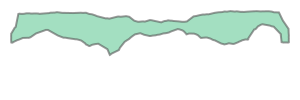

In [77]:
rvic_drainage

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


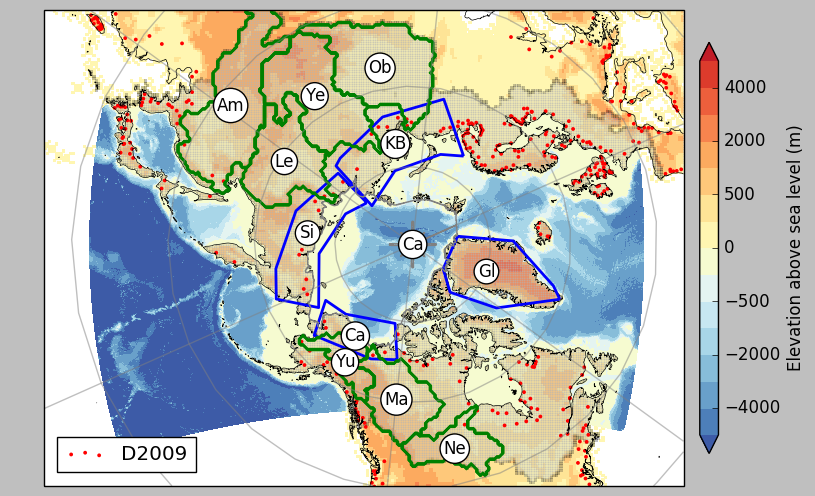

In [122]:
fig, ax = plt.subplots(figsize=(8.5, 5.5), subplot_kw=dict(projection=Rasm()))

lnd_elev.where(lnd_elev > 0).plot.pcolormesh(
    'longitude', 'latitude', ax=ax, cmap='RdYlBu_r',
    levels=levels, transform=ccrs.PlateCarree(),
    add_colorbar=False, extend='both')
wrf_rvic_masks.mask_rvic_drainage.where(wrf_rvic_masks.mask_rvic_drainage > 0).plot.pcolormesh(
    'xc', 'yc', ax=ax, cmap='gray',
    vmin=0, vmax=1.4, transform=ccrs.PlateCarree(),
    add_colorbar=False, alpha=0.25)
mappable = ocean_depth.where(ocn_mask > 0).plot.pcolormesh(
    'longitude', 'latitude', ax=ax, cmap='RdYlBu_r',
    levels=levels, transform=ccrs.PlateCarree(),
    add_colorbar=False, extend='both')

ax.coastlines(resolution='50m', lw=0.5, color='k')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='-')

river_masks = ['mask_amur',
               'mask_ob',
               'mask_yenisey',
               'mask_lena',
               'mask_mackenzie',
               'mask_nelson',
               'mask_yukon']
labels = ['Am', 'Ob', 'Ye', 'Le', 'Ma', 'Ne', 'Yu']

for r, l in zip(river_masks, labels):
    da = (wrf_rvic_masks[r] > 0.5)
    da.plot.contour('xc', 'yc', ax=ax, colors='green',
                    transform=ccrs.PlateCarree(),
                    add_colorbar=False, lw=0.7)
    x, y = map(int, center_of_mass(da.values))
    lon = da.xc.isel(ni=y, nj=x)
    lat = da.yc.isel(ni=y, nj=x)
    at_x, at_y = ax.projection.transform_point(lon, lat,
                                               src_crs=ccrs.PlateCarree())
    
    bbox_props = dict(boxstyle="circle,pad=0.2", fc="white", ec="k", lw=1)
    t = ax.text(at_x, at_y, l, ha="center", va="center", rotation=0,
            size=12,
            bbox=bbox_props)
    
ax.scatter(dai_obs.lon, dai_obs.lat, transform=ccrs.PlateCarree(),
           marker='.', facecolor='red', edgecolor='none', s=30,
           label='D2009')

coast_masks = ['shelf', 'canada', 'kara_barrents']

labels = ['Si', 'Ca', 'KB']
for i, key in enumerate(coast_masks):
    l = labels[i]
    poly = LinearRing(shapes[key])
    ax.add_geometries([poly], ccrs.PlateCarree(),
                  facecolor='none', edgecolor='blue', lw=2)
    x, y = poly.centroid.coords.xy
    lon, lat = x[0], y[0]
    at_x, at_y = ax.projection.transform_point(lon, lat,
                                               src_crs=ccrs.PlateCarree())
    
    bbox_props = dict(boxstyle="circle,pad=0.2", fc="white", ec="k", lw=1)
    t = ax.text(at_x, at_y, l, ha="center", va="center", rotation=0,
            size=12,
            bbox=bbox_props)

# Greenland
ax.add_geometries([gl_hull], ccrs.PlateCarree(),
                  facecolor='none', edgecolor='blue', lw=2)
x, y = gl_hull.centroid.coords.xy
lon, lat = x[0], y[0]
at_x, at_y = ax.projection.transform_point(lon, lat,
                                           src_crs=ccrs.PlateCarree())
bbox_props = dict(boxstyle="circle,pad=0.2", fc="white", ec="k", lw=1)
t = ax.text(at_x, at_y, 'Gl', ha="center", va="center", rotation=0,
        size=12,
        bbox=bbox_props)

# Central Arctic
# pop_cice_masks['mask_centralarctic'].plot.contour('longitude', 'latitude',
#                                                   ax=ax, colors='blue',
#                                                   transform=ccrs.PlateCarree(),
#                                                   add_colorbar=False, lw=0.7)

ax.add_geometries([concave_hull.exterior], ccrs.PlateCarree(),
                  facecolor='none', edgecolor='gray', lw=1)
x, y = concave_hull.centroid.coords.xy
lon, lat = x[0], y[0]
at_x, at_y = ax.projection.transform_point(0, 90,
                                           src_crs=ccrs.PlateCarree())

bbox_props = dict(boxstyle="circle,pad=0.2", fc="white", ec="k", lw=1)
t = ax.text(at_x, at_y, 'Ca', ha="center", va="center", rotation=0,
        size=12,
        bbox=bbox_props)

cbar = plt.colorbar(mappable=mappable, orientation='vertical', shrink=0.8, pad=0.02)

cbar.set_label('Elevation above sea level (m)')

ax.legend(loc=(0.07, 0.03))

fig.tight_layout()

fig.savefig('../figs/RASM_domain_fig.png', dpi=300)

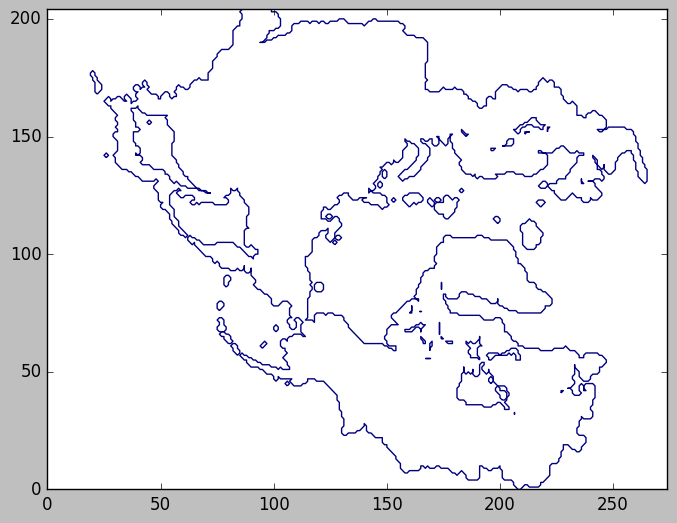

In [109]:
plt.contour(wrf_rvic_masks.mask_rvic_drainage.to_masked_array(), levels=[0, 1])

IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing


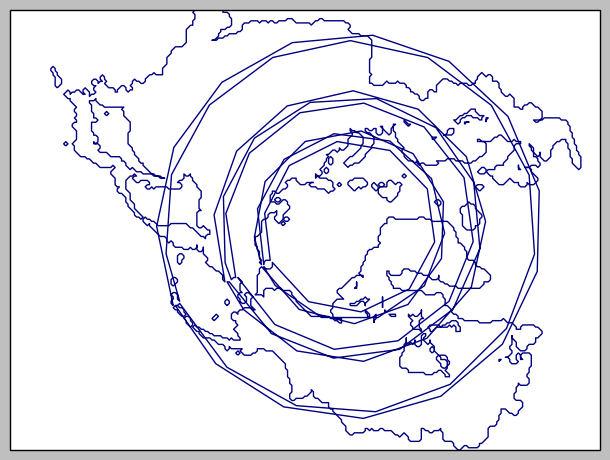

In [105]:
fig, ax = plt.subplots(figsize=(8.5, 5.5), subplot_kw=dict(projection=ccrs.NorthPolarStereo(-114)))

# wrf_rvic_masks.mask_rvic_drainage.plot.contour('xc', 'yc', levels=[0, 1], ax=ax, transform=ccrs.PlateCarree())

x = wrf_rvic_masks.xc.values
x[x > 180] -= 360

ax.contour(x, wrf_rvic_masks.yc, 
           wrf_rvic_masks.mask_rvic_drainage.to_masked_array(), 
           levels=[0, 1], transform=ccrs.PlateCarree())

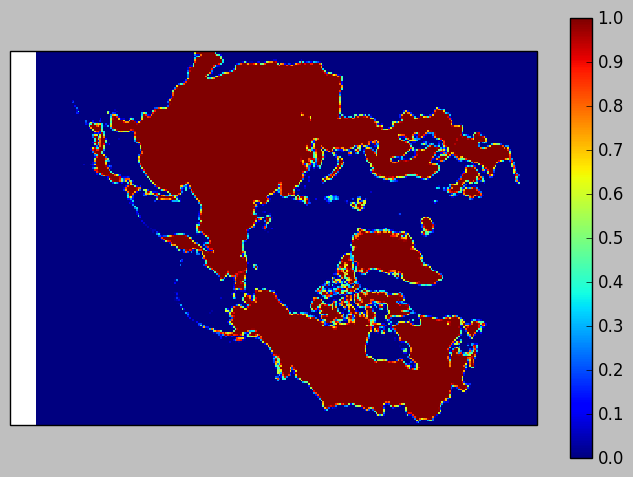

In [108]:
fig, ax = plt.subplots(figsize=(8.5, 5.5),
                       subplot_kw=dict(projection=ccrs.NorthPolarStereo(-114)))

m = ax.pcolormesh(ds.xc, ds.yc, 
                  ds.mask.to_masked_array(), 
                  transform=ccrs.PlateCarree())
plt.colorbar(mappable=m)